In [2]:
from mne import io

from pathlib import Path
import numpy as np
import pandas as pd

In [62]:
sessions = ["ses-EMS", "ses-Vibro", "ses-Visual"]
subjects = ['sub-13',
        'sub-14',
        'sub-15',
        # 'sub-12',
        'sub-08',
        'sub-06',
        'sub-07',
        'sub-11',
        'sub-16',
        'sub-02']

base_path = Path("./prediction_error_EEG/ds003846-2.0.2")

ica_sessions = {s: [] for s in sessions}
session2event = {s: [] for s in sessions}


for session in sessions:
    for subject in subjects:
        # load the dataset

        data = io.read_raw_fif(f"multivariate_data/processed_dataset/{subject}/{session}_processed_raw.fif")
        # ica_sessions[s] = io.read_raw_fif("/Users/Milana/Documents/university/eeg_block/ds003846-2.0.2/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_events.tsv")
        ica_sessions[session].append(data)


        events_file = base_path / subject / session / "eeg" /f"{subject}_{session}_task-PredictionError_events.tsv"
        print(events_file)
        events_df = pd.read_csv(events_file, sep="\t")

        # Map events
        events = []
        for _, row in events_df.iterrows():
            event_dict = dict(item.split(":") for item in row["value"].split(";"))

            if "box" in event_dict and event_dict["box"] == "touched":
                sample = int(row["sample"])
                onset_in_sec = float(row["onset"])
                sample_index = int(round(onset_in_sec * raw.info["sfreq"]))

                events.append([sample_index, 0, event_id[event_dict["normal_or_conflict"]]])
        
        session2event[session].append(np.array(events))

Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_dataset/sub-13/ses-EMS_processed_raw.fif...
    Range : 0 ... 183917 =      0.000 ...   735.668 secs
Ready.
/Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2/sub-13/ses-EMS/eeg/sub-13_ses-EMS_task-PredictionError_events.tsv
Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_dataset/sub-14/ses-EMS_processed_raw.fif...
    Range : 0 ... 195397 =      0.000 ...   781.588 secs
Ready.
/Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2/sub-14/ses-EMS/eeg/sub-14_ses-EMS_task-PredictionError_events.tsv
Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_dataset/sub-15/ses-EMS_processed_raw.fif...
    Range : 0 ... 171767 =      0.000 ...   687.068 secs
Ready.
/Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2/sub-15/ses-EMS/e

In [58]:
import mne

In [59]:
ica_sessions_processed = {}

for k, events in ica_sessions.items():
    ica_sessions_processed[k] = mne.concatenate_raws(events)

In [60]:
from pathlib import Path
import numpy as np
import pandas as pd

In [61]:
session2event = {s: [] for s in sessions}
base_path = Path("./ds003846-2.0.2")

event_id = {"normal": 2, "conflict": 3}

for session in sessions:
    for subj in subjects:
        data_paths = {
            "ses-EMS": base_path / subject / "ses-EMS" / "eeg",
            "ses-Visual": base_path / subject / "ses-Visual" / "eeg",
            "ses-Vibro": base_path / subject / "ses-Vibro" / "eeg"
        }
        events_file = data_paths[session] / f"{subject}_{session}_task-PredictionError_events.tsv"
        events_df = pd.read_csv(events_file, sep="\t")

        # Map events
        events = []
        for _, row in events_df.iterrows():
            event_dict = dict(item.split(":") for item in row["value"].split(";"))

            if "box" in event_dict and event_dict["box"] == "touched":
                sample = int(row["sample"])
                onset_in_sec = float(row["onset"])
                sample_index = int(round(onset_in_sec * raw.info["sfreq"]))

                events.append([sample_index, 0, event_id[event_dict["normal_or_conflict"]]])
        
        session2event[session].append(np.array(events))

In [42]:
for s in session2event:
    session2event[s] = np.concatenate(session2event[s])

In [65]:
epochs_sessions = {}
tmin, tmax = -0.3, 0.7
event_id = {"normal": 2, "conflict": 3}

for session, raw in ica_sessions_processed.items():
    print(f"Creating stimulus-aligned epochs for {session}...")
    # Extract events
    # Epoching, drop duplicate event too
    events = session2event[session]
    events = np.concatenate(events)

    epochs = mne.Epochs(
        raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
        baseline=(None, 0), preload=True, event_repeated="drop"
    )
    epochs_sessions[session] = epochs
    print(f"Extracted {len(epochs)} epochs for {session}.")

Creating stimulus-aligned epochs for ses-EMS...
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1853 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1853 events and 251 original time points ...
0 bad epochs dropped
Extracted 1853 epochs for ses-EMS.
Creating stimulus-aligned epochs for ses-Vibro...
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
3104 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3104 events and 251 original time points ...
0 bad epochs dropped
Extracted 3104 epochs for ses-Vibro.
Creating stimulus-aligned epochs for ses-Visual...
Multiple event values for single event times found. Keeping the first occurre

**Epoch Rejection (Step 7)**

Following the paper, we reject the 10% noisiest epochs. 

In [66]:
for session, epochs in epochs_sessions.items():
    # print(f"Rejecting 10% of noisiest epochs for {session}...")
    # reject_criteria = dict(eeg=200e-6)  # need to find a good threshold

    # epochs.drop_bad(reject=reject_criteria)
    # Calculate peak-to-peak amplitudes
    peak_to_peak = np.ptp(epochs.get_data(), axis=2).mean(axis=1)

    # Find the 10% noisiest epochs
    threshold = np.percentile(peak_to_peak, 80)  # 90th percentile
    noisy_epochs = peak_to_peak > threshold

    # Drop the noisiest epochs
    epochs.drop(indices=np.where(noisy_epochs)[0], reason='manual')

Dropped 371 epochs: 0, 1, 2, 3, 4, 5, 10, 11, 20, 21, 22, 23, 24, 25, 26, 27, 34, 35, 36, 37, 261, 262, 268, 269, 276, 277, 278, 279, 284, 285, 344, 345, 352, 353, 354, 355, 390, 391, 392, 393, 394, 395, 414, 415, 416, 417, 430, 431, 483, 484, 485, 486, 523, 524, 563, 564, 580, 581, 598, 599, 600, 601, 616, 617, 618, 619, 620, 621, 622, 623, 696, 697, 700, 701, 720, 721, 722, 723, 772, 773, 774, 775, 776, 777, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 798, 799, 800, 801, 802, 803, 804, 805, 806, 813, 814, 831, 832, 833, 834, 835, 836, 847, 848, 849, 850, 851, 852, 855, 856, 857, 858, 863, 864, 865, 868, 869, 870, 871, 872, 873, 884, 885, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 912, 913, 914, 915, 922, 923, 924, 925, 926, 927, 932, 933, 954, 955, 956, 957, 958, 959, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 980, 981, 1001, 1002, 1003, 1004, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1049, 1050, 1051

**ERP Analysis (step 8)**

In [67]:
epochs_sessions

{'ses-EMS': <Epochs | 1482 events (all good), -0.3 – 0.7 s (baseline -0.3 – 0 s), ~184.6 MiB, data loaded,
  'normal': 1118
  'conflict': 364>,
 'ses-Vibro': <Epochs | 2483 events (all good), -0.3 – 0.7 s (baseline -0.3 – 0 s), ~309.2 MiB, data loaded,
  'normal': 1855
  'conflict': 628>,
 'ses-Visual': <Epochs | 2156 events (all good), -0.3 – 0.7 s (baseline -0.3 – 0 s), ~268.5 MiB, data loaded,
  'normal': 1612
  'conflict': 544>}

/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_25280/3579126260.py:12: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_25280/3579126260.py:12: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_25280/3579126260.py:12: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_25280/3579126260.py:31: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  plot_compare_evokeds(
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_25280/3579126260.py:42: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  plot_compare_evokeds(
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_25280/3579126260.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


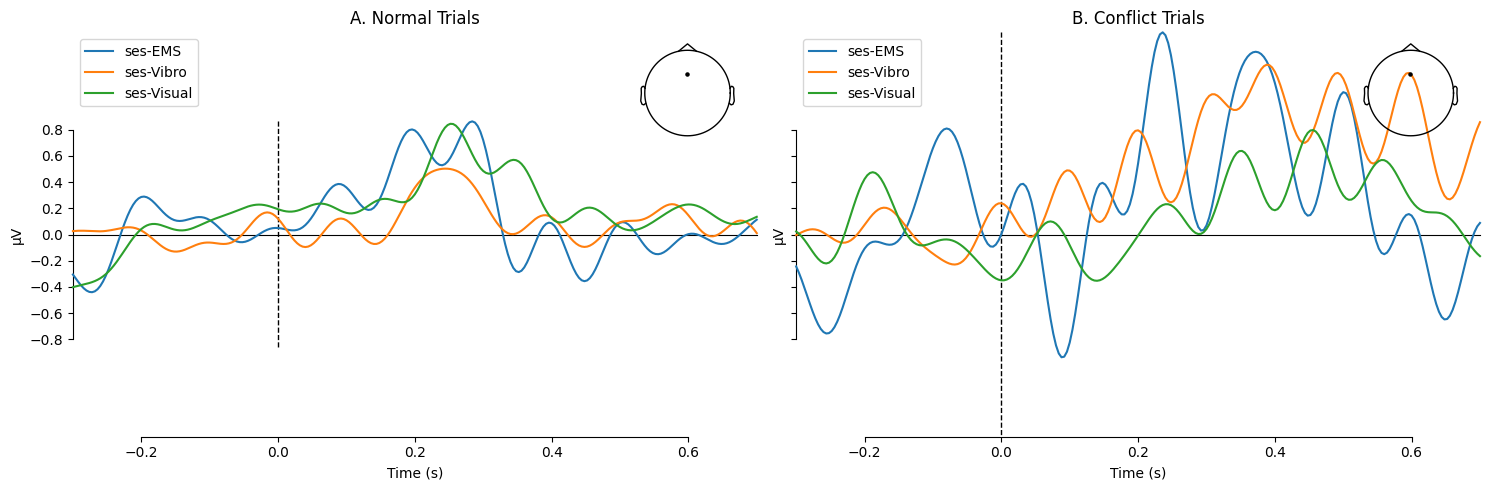

In [68]:
from mne.viz import plot_compare_evokeds

import matplotlib.pyplot as plt

# 1) Collect average Evokeds per session into two dicts: one for "normal" and one for "conflict"
evokeds_normal = {}
evokeds_conflict = {}
evokeds_difference = {}

for session, epochs in epochs_sessions.items():
    # Apply a 10 Hz low-pass filter to the epochs
    epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)

    # Average each condition at FCz
    evoked_normal = epochs_filtered["normal"].average(picks="FCz")
    evoked_conflict = epochs_filtered["conflict"].average(picks="FCz")

    # Calculate the difference (Conflict - Normal)
    evoked_diff = evoked_conflict.copy()
    evoked_diff.data = evoked_conflict.data - evoked_normal.data

    # Store them by session name
    evokeds_normal[session] = evoked_normal
    evokeds_conflict[session] = evoked_conflict
    evokeds_difference[session] = evoked_diff

# 2) Create three side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# --- Left subplot: Normal ---
plot_compare_evokeds(
    evokeds_normal,        # dictionary of Evoked objects (one per session)
    picks="FCz",
    combine="mean",        # plot the FCz signal directly (no averaging across channels)
    ci=False,              # if you only have single-subject data per session, disable shading
    axes=axes[0],
    title="A. Normal Trials",
    show=False
)

# --- Middle subplot: Conflict ---
plot_compare_evokeds(
    evokeds_conflict,
    picks="FCz",
    combine="mean",
    ci=False,
    axes=axes[1],
    title="B. Conflict Trials",
    show=False
)

# # --- Right subplot: Difference (Conflict - Normal) ---
# plot_compare_evokeds(
#     evokeds_difference,
#     picks="FCz",
#     combine="mean",
#     ci=False,
#     axes=axes[2],
#     title="C. Difference (Conflict - Normal)",
#     show=False
# )

# Finalize and display the plot
plt.tight_layout()
plt.show()
